### Install package

In [1]:
!pip install pytorch-adapt[ignite] seaborn pandas umap-learn

     |████████████████████████████████| 137 kB 5.3 MB/s 
     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 397 kB 21.4 MB/s 
     |████████████████████████████████| 106 kB 12.0 MB/s 
     |████████████████████████████████| 254 kB 32.7 MB/s 
     |████████████████████████████████| 1.1 MB 36.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=50343c03de27bdc3c6e5f196249f1af111e0ff8f4e0c7b47e60eeb1716e586e2
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=118e4260952c6bbf67b54c263bf83b3a69df68e86524fc7ebb43f516df21b05f
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


### Import packages

In [2]:
import logging

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import umap
from ignite.engine import Events

from pytorch_adapt.adapters import DANN
from pytorch_adapt.containers import Models, Optimizers
from pytorch_adapt.datasets import DataloaderCreator, get_mnist_mnistm
from pytorch_adapt.frameworks.ignite import Ignite, CheckpointFnCreator
from pytorch_adapt.models import Discriminator, mnistC, mnistG
from pytorch_adapt.validators import AccuracyValidator, IMValidator, ScoreHistory

logging.basicConfig()
logging.getLogger("pytorch-adapt").setLevel(logging.INFO)

In [3]:
class VizHook:
    def __init__(self):
        self.required_data = ["src_val", "target_val"]

    def __call__(self, epoch, src_val, target_val, **kwargs):
        if epoch % 2 != 0:
            return
        features = [src_val["features"], target_val["features"]]
        domain = [src_val["domain"], target_val["domain"]]
        features = torch.cat(features, dim=0).cpu().numpy()
        domain = torch.cat(domain, dim=0).cpu().numpy()
        emb = umap.UMAP().fit_transform(features)

        df = pd.DataFrame(emb).assign(domain=domain)
        df["domain"] = df["domain"].replace({0: "Source", 1: "Target"})
        sns.set_theme(style="white", rc={"figure.figsize": (12.8, 9.6)})
        sns.scatterplot(data=df, x=0, y=1, hue="domain", s=2)
        plt.show()


### Create datasets and dataloaders

In [4]:
datasets = get_mnist_mnistm(["mnist"], ["mnistm"], folder=".", download=True)
dc = DataloaderCreator(batch_size=64, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/134178716 [00:00<?, ?it/s]

INFO:pytorch-adapt:Extracting dataset
100%|██████████| 68007/68007 [00:25<00:00, 2649.62it/s]


### Create models, optimizers, hook, and validator

In [5]:
G = mnistG(pretrained=True)
C = mnistC(pretrained=True)
# move first 6 layers of C to G
G.fc = C.net[:6]
C.net = C.net[6:]

D = Discriminator(in_size=128, h=256)
models = Models({"G": G, "C": C, "D": D})
optimizers = Optimizers((torch.optim.Adam, {"lr": 0.0005}))

adapter = DANN(models=models, optimizers=optimizers)
checkpoint_fn = CheckpointFnCreator(dirname="saved_models", require_empty=False)
validator = ScoreHistory(IMValidator())
val_hooks = [ScoreHistory(AccuracyValidator()), VizHook()]
trainer = Ignite(adapter, validator=validator, val_hooks=val_hooks, checkpoint_fn=checkpoint_fn)

Downloading: "https://cornell.box.com/shared/static/tdx0ts24e273j7mf3r2ox7a12xh4fdfy" to /root/.cache/torch/hub/checkpoints/mnistG-68ee7945.pth


  0%|          | 0.00/161k [00:00<?, ?B/s]

Downloading: "https://cornell.box.com/shared/static/j4zrogronmievq1csulrkai7zjm27gcq" to /root/.cache/torch/hub/checkpoints/mnistC-ac7b5a13.pth


  0%|          | 0.00/1.31M [00:00<?, ?B/s]

### Train and evaluate

INFO:pytorch-adapt:Collecting target_train
INFO:pytorch-adapt:Setting models to eval() mode


[1/922]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


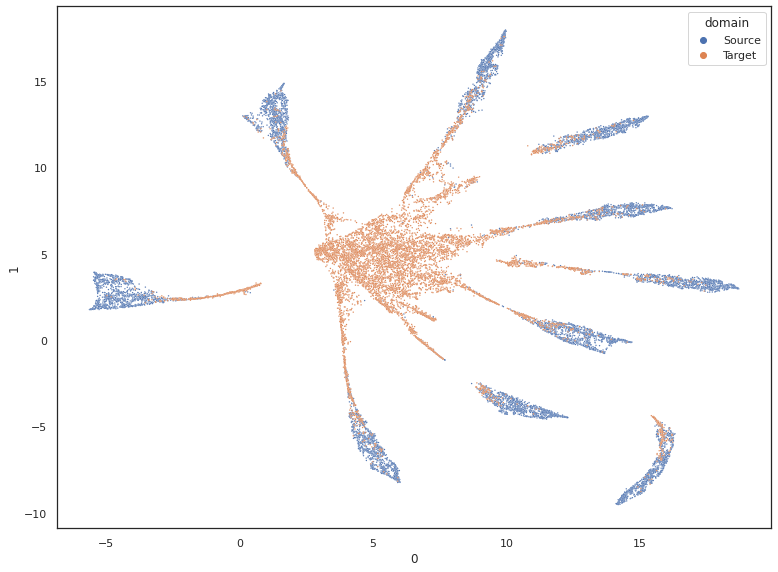

INFO:pytorch-adapt:Setting models to train() mode


[1/921]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_train
INFO:pytorch-adapt:Setting models to eval() mode


[1/922]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Setting models to train() mode


[1/921]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_train
INFO:pytorch-adapt:Setting models to eval() mode


[1/922]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

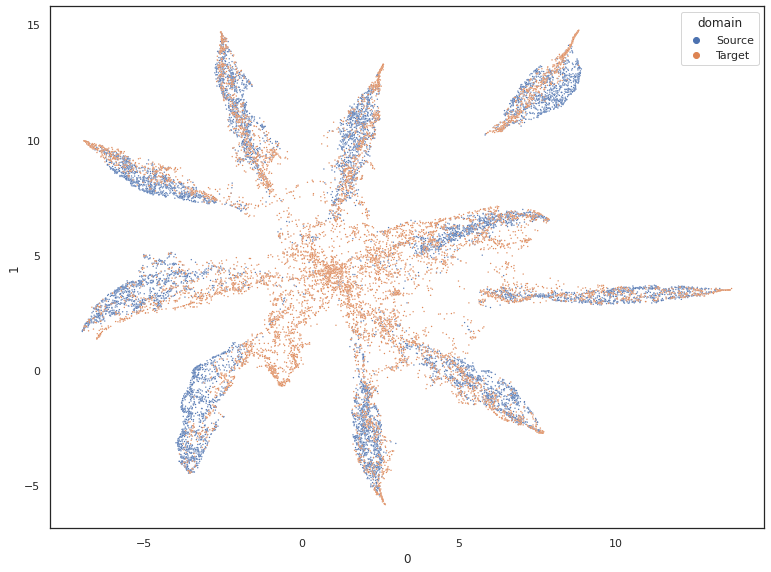

INFO:pytorch-adapt:Setting models to train() mode


[1/921]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_train
INFO:pytorch-adapt:Setting models to eval() mode


[1/922]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Setting models to train() mode


[1/921]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_train
INFO:pytorch-adapt:Setting models to eval() mode


[1/922]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

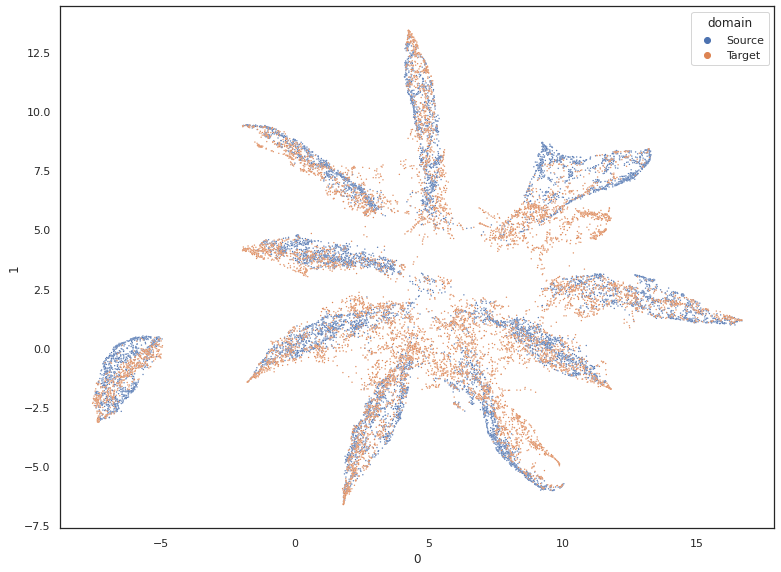

best_score=1.1286897659301758, best_epoch=4


In [6]:
best_score, best_epoch = trainer.run(datasets, dataloader_creator=dc, max_epochs=4, check_initial_score=True)
print(f"best_score={best_score}, best_epoch={best_epoch}")

### Print score histories

In [7]:
print("validator score history", validator.score_history)
print("src_val accuracy history", val_hooks[0].score_history)

validator score history [0.95713174 1.06535375 0.15787119 0.95764758 1.12868977]
src_val accuracy history [0.99510002 0.98710001 0.99220002 0.99000001 0.98900002]


### Check accuracy on target data (not possible in real-world applications)

In [8]:
datasets = get_mnist_mnistm(
    ["mnist"], ["mnistm"], folder=".", return_target_with_labels=True
)
dc = DataloaderCreator(batch_size=64, num_workers=2, all_val=True)
validator = AccuracyValidator(key_map={"target_val_with_labels": "src_val"})
score = trainer.evaluate_best_model(datasets, validator, dc)
print(score)

INFO:pytorch-adapt:***EVALUATING BEST MODEL***
INFO:pytorch-adapt:Collecting target_val_with_labels
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

0.648261308670044
